### Libraries

In [1]:
# Importing the libraries
import pandas as pd
from IPython.display import Image, HTML
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

### Dataset

In [2]:
# Importing the dataset
listings = pd.read_csv('s3://fc-uk-data/datalake/blue-tigers/risk_model_data/R&D Datasets/airbnb-data/listings.csv', usecols = ['id', 'name', 'description'])


In [3]:
print(listings.shape)
listings.head(3)

(3818, 3)


,id,name,description
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...


### Exploratory Data Analysis

In [4]:
listings['name'] = listings['name'].astype('str')
listings['description'] = listings['description'].astype('str')

In [5]:
name_corpus = ' '.join(listings['name'])
description_corpus = ' '.join(listings['description'])

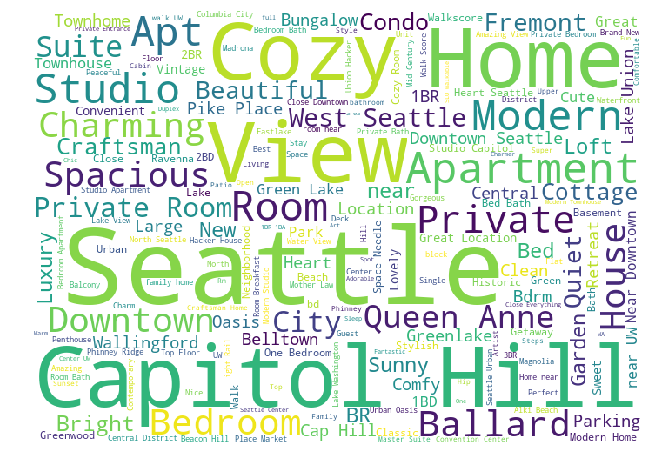

In [6]:
name_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 500, width = 700).generate(name_corpus)
plt.figure(figsize = (16,8))
plt.imshow(name_wordcloud)
plt.axis('off')
plt.show()

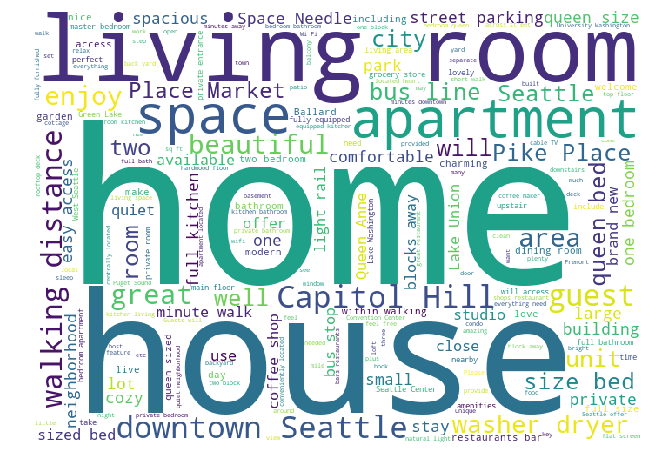

In [7]:
description_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 500, width = 700).generate(description_corpus)
plt.figure(figsize = (16,8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

In [8]:
listings['content'] = listings[['name', 'description']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)

In [9]:
# Fillna
listings['content'].fillna('Null', inplace = True)

### Train the Recommender

In [10]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(listings['content'])

#### Cosine Similarity

In [11]:
'''linear_matrix and cosine_similarity output are same. linear_matrix is faster'''
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix) # faster than cosine_similarity
# cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [12]:
results = {}
for idx, row in listings.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], listings['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]

##### User Defined Functions for Predictions

In [13]:
def item(id):
    name   = listings.loc[listings['id'] == id]['content'].tolist()[0].split(' // ')[0]
    desc   = ' \nDescription: ' + listings.loc[listings['id'] == id]['content'].tolist()[0].split(' // ')[1][0:101] + '...'
    prediction = name  + desc
    return prediction

def recommend(item_id, num):
    print('Recommending ' + str(num) + ' products similar to ' + item(item_id))
    print('---')
    recs = results[item_id][:num]
    for rec in recs:
        print('\nRecommended: ' + item(rec[1]) + '\n(score:' + str(rec[0]) + ')')

In [14]:
recommend(item_id = 2487892, num = 5)

Recommending 5 products similar to Two blocks from downtown Ballard 
Description: Private room & bathroom two blocks from grocery stores, independent shops, and some of the best resta...
---

Recommended: Bedroom & private bath in Ballard 
Description: This clean bedroom has a private bathroom, closet, and full-size bed. Conveniently located mere block...
(score:0.09734275181851604)

Recommended: Ballard Private Room w Double Bed 
Description: My house is in one of Seattle's most desirable neighborhoods, Ballard. It's walking distance to the B...
(score:0.09477344853565917)

Recommended: Ballard Private Room w Queen Bed 
Description: This bright and sunny apartment with garden patio has two bedrooms. The apt can be rented in its enti...
(score:0.08474887976753032)

Recommended: Private Room in Roosevelt 
Description: Private room with queen size bed and closet space.  Private bathroom with shower.  Washer and dryer a...
(score:0.08205828976705876)

Recommended: Cozy BR in heart of live

### ** End ** ###